# INTRODUCTION TO CATAN

Settlers of Catan, or simply Catan, is a strategic board game created by Klaus Teuber. Since its release in 1995, the game has garnered a dedicated following due to its engaging blend of strategy, negotiation, and chance. In Catan, players assume the roles of settlers aiming to build and develop holdings while trading and acquiring resources. The game is played on a board composed of 18 hexagonal tiles representing different types of terrain, each producing one of five resources: wood, brick, sheep, wheat, or ore. The arrangement of these tiles and the placement of numbers that determine resource production are crucial to the game's strategic depth. Additionaly, there is a desert tile with no resources, and therefore no number places on it.

![catan](catan-board-game-layout.jpg)

The objective of this project is to explore the mathematical optimization of the Catan board setup to enhance the strategic experience of the game. Specifically, we aim to design an optimal board configuration that adheres to the standard rules while maximizing strategic balance and fairness. The evaluation criteria for the board configuration are encapsulated in a carefully constructed objective function that accounts for resource distribution, tile variety, and number placement.

By employing various optimization algorithms, we seek to determine a board setup that provides a balanced and challenging environment for players. This approach not only deepens our understanding of the game’s mechanics but also demonstrates the practical applications of mathematical optimization techniques in game design.

In [1]:
import random
import time
import numpy as np
import pandas as pd

from utility import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# OBJECTIVE FUNCTION

In this problem, we have three main objectives for optimizing the balance of the Catan board:

- Minimize penalty for resource adjacency.
- Minimize penalty if numbers 6 and 8 are adjacent.
- Minimize the least squares function to ensure balanced probabilities of resource occurrences between two groups.


First we will go into detail those components of objective function:
1. **Penalty for resource adjacency**: Define a penalty function that calculates the penalty based on the adjacency of resources. For example, penalize more if high-value resources (like sheep, wood, wheat) are adjacent.
2. **Penalty if numbers 6 and 8 are adjacent**: Define a penalty function that penalizes configurations where the numbers 6 and 8 are adjacent.
3. **Balance of resource probability**: Define the balance of resource probability by categorizing resources into two groups based on their occurrence frequencies. Group 1 includes sheep, wood, and wheat, each appearing four times, while group 2 consists of brick and stone, each appearing three times. We calculate the probabilities of each resource appearing on the map and then use a least squares function to ensure these probabilities are balanced within each group.

$$
LS_{group1} = {\sqrt{\frac{1}{3}\sum_{i\ in\  group1}(p_{i}- \bar{p}_{group1})^2}}
$$

$$
LS_{group2} = {\sqrt{\frac{1}{2}\sum_{i\ in\  group2}(p_{i}- \bar{p}_{group2})^2}}
$$

**General Objective Function**

Those small component will be combined with appropriate weights 𝑤 to generate an overal objective function of Catan balance map:

$$
J = {w_{1}.P_{resource\_adjacency} + w_{2}.P_{6\&8\_adjacency} + w_{3}.LS_{group1} + w_{4}.LS_{group2}}
$$

So now, our **optimization goal** in this problem is **minimize J** using an optimization algorithm suitable for discrete optimization problems, such as simulated annealing, genetic algorithms, or other heuristic methods..

In [2]:
# Function to evaluate solution score and resource probabilities
def evaluate_solution(solution, weight=[20, 1, 10, 10]):
    resource_probs = {'brick':0,
                      'wood':0,
                      'sheep':0,
                      'wheat':0,
                      'stone':0}
    high_value_adjacent_penalty = 0
    resource_adjacency_penalty = 0
    
    # Dice roll probabilities
    dice_probabilities = {2: 1/36, 3: 2/36, 4: 3/36, 5: 4/36, 6: 5/36, 8: 5/36, 9: 4/36, 10: 3/36, 11: 2/36, 12: 1/36}

    for i, tile in enumerate(solution):
        resource, number = tile
        # High-value number adjacency check
        if number in [6, 8]:
            for neighbor in neighbors[i]:
                if solution[neighbor][1] in [6, 8]:
                    high_value_adjacent_penalty += 1

        # Resource adjacency check
        for neighbor in neighbors[i]:
            if solution[neighbor][0] == resource:
                resource_adjacency_penalty += 1

        # Dice roll probability balance
        if resource != 'desert':
            resource_probs[resource] += dice_probabilities[number]
    
    avg_resource_4 =  (resource_probs['sheep'] + resource_probs['wheat'] + resource_probs['wood'])/3
    balance_resource_4 =  np.sqrt(1/3 * ((resource_probs['sheep'] - avg_resource_4)**2 +  \
                                         (resource_probs['wheat'] - avg_resource_4)**2 +  \
                                            (resource_probs['wood'] - avg_resource_4)**2))
    avg_resource_3 =  (resource_probs['brick'] + resource_probs['stone'] )/2
    balance_resource_3 =  np.sqrt(1/2 * ((resource_probs['brick'] - avg_resource_3)**2 +  \
                                            (resource_probs['stone'] - avg_resource_3)**2))
   
    score = (high_value_adjacent_penalty*weight[0] + resource_adjacency_penalty*weight[1] + balance_resource_4*weight[2] + balance_resource_3*weight[3]
             )
    return score, resource_probs

# ALGORITHMS

## Metaheuristics

Metaheuristics are a class of algorithms designed to solve complex optimization problems that are otherwise difficult to address using traditional methods. These algorithms provide approximate solutions within a reasonable time frame and are especially useful for problems where the search space is large, multidimensional, or lacks a clear structure.

#### Key Characteristics of Metaheuristics

1. **General Applicability**:
   - Metaheuristics are not problem-specific; they can be applied to a wide variety of optimization problems across different domains, from engineering to economics.

2. **Exploration and Exploitation**:
   - These algorithms balance two key processes: exploration (searching through diverse solutions) and exploitation (refining the current best solutions). This balance helps avoid local optima and increases the chances of finding a global optimum.

3. **Stochastic Nature**:
   - Metaheuristics often incorporate randomness in their search processes, making them less likely to get stuck in suboptimal solutions and providing a robust way to navigate complex search spaces.

4. **Iterative Process**:
   - Most metaheuristics operate through iterative improvement, gradually enhancing the solution based on a defined fitness or objective function.

#### Used Metaheuristic Algorithms

1. **Genetic Algorithms (GA)**:
   - Inspired by the principles of natural selection and genetics, GA uses a population of solutions, applying operators like selection, crossover, and mutation to evolve better solutions over generations.

2. **Simulated Annealing (SA)**:
   - Based on the annealing process in metallurgy, SA probabilistically decides to accept worse solutions in the short term to escape local minima, gradually reducing the probability as the algorithm progresses.

3. **Ant Colony Optimization (ACO)**:
   - Inspired by the foraging behavior of ants, ACO uses artificial ants that build solutions by moving on the problem's graph and depositing pheromones, guiding future ants towards promising regions of the search space.

4. **Artificial Bee Colony (ABC)**:
   - Modeled after the foraging behavior of honey bees, ABC divides the search process into employed bees, onlookers, and scouts, collaboratively searching for and exploiting food sources (solutions).

#### Advantages of Metaheuristics

Metaheuristics offer several advantages, making them valuable tools for solving complex optimization problems. One of the primary benefits is their **flexibility**. Metaheuristics can be adapted to a wide range of problems without requiring significant modifications. This adaptability allows them to be applied across various domains, from engineering and logistics to finance and biology, making them versatile solutions for diverse optimization challenges. Another advantage is their **efficiency**. Metaheuristics are capable of finding good-quality solutions within a reasonable computational time. Unlike exact algorithms that may take an impractically long time to solve complex problems, metaheuristics provide approximate solutions quickly, which is often sufficient for practical applications. This efficiency is particularly important in real-world scenarios where time and computational resources are limited. Metaheuristics are also known for their **scalability**. They are suitable for both small-scale and large-scale problems, handling extensive search spaces effectively. This scalability ensures that metaheuristics can be employed for optimization tasks of varying sizes and complexities, maintaining their performance across different problem scales.

#### Challenges and Considerations

Despite their advantages, metaheuristics also present certain challenges and considerations. One of the main challenges is **parameter tuning**. Metaheuristics often require careful tuning of parameters to achieve optimal performance, and these parameters can be problem-specific. Finding the right combination of parameters, such as population size, mutation rate, or cooling schedule, can significantly impact the algorithm's effectiveness and requires experimentation and experience. Another critical consideration is the **balance of exploration and exploitation**. Ensuring the right balance between exploring new areas of the search space (exploration) and refining the best-found solutions (exploitation) is crucial for the effectiveness of the algorithm. An imbalance can lead to premature convergence to suboptimal solutions or excessive exploration without finding high-quality solutions. Therefore, designing mechanisms to maintain this balance is a key aspect of developing effective metaheuristic algorithms. Finally, while metaheuristics provide approximate solutions, the **quality of solutions** can vary. There is no guarantee of finding the global optimum, and the solutions obtained are often dependent on the specific run of the algorithm. This variability means that while metaheuristics can offer good solutions, they may not always find the best possible solution, especially in highly complex or poorly understood search spaces. Understanding these limitations is essential when applying metaheuristics to real-world optimization problems.

## Ant Colony Optimization

**Ant Colony Optimization (ACO)** is a metaheuristic inspired by the **foraging behavior of ants**, used to find optimal solutions for combinatorial optimization problems. It mimics the process of ants searching for food and **laying down pheromone trails to communicate with other ants**. After evaluating multiple configurations formed by an initial group of ants, it identifies the optimal board configuration with the lowest score, reflecting a balanced and optimized placement of resources and number tokens on the Catan board. Each board configuration created by each individual ant receives a certain amount of pheromone based on its evaluation score, which serves as a grade of how good that ant's solution was. In the next iteration, another group of ants will configure a board, now informed by the previous ant expeditions through the pheromone trails.

*Parameters:*

- num_iterations: Number of iterations for ant exploration.
- num_ants: Number of ants per iteration.
- alpha: Pheromone influence parameter.
- beta: Heuristic influence parameter.
- evaporation_rate: Rate at which pheromone evaporates over iterations.

**Algorithm Preparation:**

1. **Calculate Transition Probabilities (`calculate_transition_probabilities`):**
   - Computes probabilities for ants to move from one tile to another based on pheromone levels and heuristic information (`alpha` and `beta`).

2. **Create Initial Solution (`create_initial_solution`):**
   - Generates a random initial solution by assigning resource tiles and number tokens on the board, ensuring proper distribution and avoiding adjacency issues.

3. **Ant Colony Optimization (`ant_colony_optimization`):**
   - Iteratively constructs solutions by simulating ant behavior.
   - Updates pheromone levels based on solution quality and evaporates older trails.
   - Returns the best solution found, its score, resource pde based on specific implementation details and findings.lementation details and findings.

### Implementation

In [16]:
def ant_colony_optimization(num_iterations=1000, num_ants=10, alpha=1.0, beta=1.0, evaporation_rate=0.5):
    start_time = time.time()
    pheromone = np.ones((19, 19))
    heuristic = np.ones((19,19))  #initialize heuristic information
    best_solution = None
    best_score = float('inf')
    best_balances = []

    for iteration in range(num_iterations):
        solutions = []
        scores = []
        for ant in range(num_ants):
            solution = create_initial_solution_aco(pheromone, heuristic, alpha, beta)
            score, resource_probs = evaluate_solution(solution)
            solutions.append(solution)
            scores.append(score)
            if score < best_score:
                best_solution = solution
                best_score = score
                best_balances = resource_probs

        pheromone *= (1 - evaporation_rate)
        for solution, score in zip(solutions, scores):
            for i in range(len(solution)):
                pheromone[i, i] += 1.0 / score

    computation_time = time.time() - start_time
    return best_solution, best_score, best_balances, computation_time

Best Solution: [('stone', 6), ('wood', 11), ('wheat', 5), ('wheat', 12), ('stone', 4), ('brick', 5), ('wood', 4), ('sheep', 8), ('brick', 2), ('sheep', 11), ('wheat', 9), ('stone', 9), ('desert', None), ('wood', 10), ('brick', 6), ('sheep', 3), ('sheep', 8), ('wheat', 3), ('wood', 10)]
Best probability: {'brick': 0.2777777777777778, 'wood': 0.3055555555555555, 'sheep': 0.3888888888888889, 'wheat': 0.3055555555555556, 'stone': 0.3333333333333333}
Best Score: 2.6706148784369708
Computation Time: 8.974237203598022


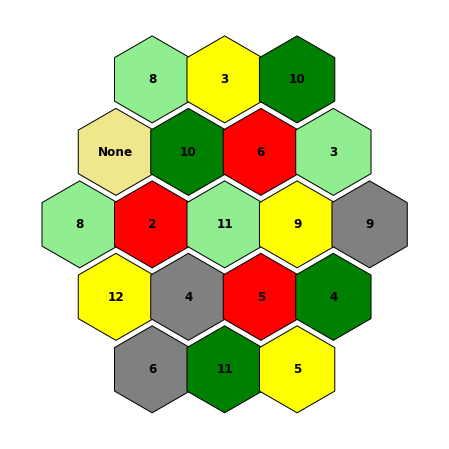

In [6]:
# Test the ACO implementation
best_solution, best_score, best_balances, computation_time = ant_colony_optimization()
print("Best Solution:", best_solution)
print("Best probability:", best_balances)
print("Best Score:", best_score)
print("Computation Time:", computation_time)
plot_solution(best_solution)

As the ACO algorithm was not covered in class, we explored the impact of adjusting the hyperparameters through various experiments. Rather than showing the different results and code, here are our findings:

**Num_iterations: Number of Iterations for Ant Exploration**
- **Definition**: The number of iterations specifies how many times the group of ants will construct solutions and update the pheromone levels.
- **Role**: More iterations allow the ants to explore the solution space more thoroughly, increasing the chances of finding an optimal or near-optimal solution.
- **Impact**:
  - **Many Iterations**: Running more iterations allows the algorithm to refine the solutions further and provides more opportunities for good solutions to emerge. However, it increases computation time.
  - **Few Iterations**: Running fewer iterations reduces computation time but may result in less thoroughly explored solutions and potentially lower-quality outcomes.

**Num_ants: Number of Ants Per Iteration**
- **Definition**: The number of ants specifies how many individual ants will construct solutions in each iteration.
- **Role**: More ants provide more candidate solutions in each iteration, increasing diversity and exploration of the solution space.
- **Impact**:
  - **Many Ants**: Using more ants increases the diversity of solutions in each iteration and helps prevent premature convergence. However, it also increases the computational load per iteration.
  - **Few Ants**: Using fewer ants reduces the computational load per iteration but may result in less diverse solutions and potentially slower convergence to good solutions.

**Alpha: Pheromone Influence Parameter**
- **Definition**: Alpha (α) determines the influence of the pheromone trails on the decision-making process of the ants.
- **Role**: Pheromones represent the accumulated knowledge of past ants' solutions. A higher alpha means that ants will rely more heavily on the pheromone trails when choosing the next component of their solution.
- **Impact**:
  - **High Alpha**: If alpha is set to a high value, ants will be strongly attracted to paths with higher pheromone levels. This can lead to quick convergence on good solutions but risks getting stuck in local optima.
  - **Low Alpha**: If alpha is set to a low value, pheromone levels will have less influence, and ants will explore the solution space more randomly. This increases exploration but can slow down convergence.

**Beta: Heuristic Influence Parameter**
- **Definition**: Beta (β) determines the influence of heuristic information on the decision-making process of the ants.
- **Role**: Heuristic information represents problem-specific knowledge that helps guide the search process. For example, it could be based on the cost, distance, or desirability of certain moves.
- **Impact**:
  - **High Beta**: If beta is set to a high value, ants will rely more heavily on heuristic information. This can help ants find good solutions faster but may reduce exploration.
  - **Low Beta**: If beta is set to a low value, heuristic information will have less influence, leading to a more random search. This increases exploration but may make it harder to find good solutions quickly.

**Evaporation Rate: Rate at Which Pheromone Evaporates Over Iterations**
- **Definition**: The evaporation rate determines how quickly pheromone levels decay over time.
- **Role**: Pheromone evaporation prevents the algorithm from converging too quickly to a suboptimal solution by reducing the influence of older pheromone trails.
- **Impact**:
  - **High Evaporation Rate**: If the evaporation rate is high, pheromone levels decay quickly. This encourages exploration and helps avoid premature convergence but may slow down the convergence process.
  - **Low Evaporation Rate**: If the evaporation rate is low, pheromone levels decay slowly. This reinforces the paths taken by previous ants, leading to faster convergence but increasing the risk of getting stuck in local optima.

### Parameter Tuning for Ant Colony Optimization

To find the most optimal set of hyperparameters for the Ant Colony Optimization (ACO) algorithm, we performed a rough parameter search. This involves evaluating the performance of the algorithm across a range of possible hyperparameter values and selecting the combination that yields the best results.

*Parameter Ranges:*

- num_iterations_range: [100, 500, 1000]
- num_ants_range: [5, 10, 20]
- alpha_range: [0.5, 1.0, 2.0]
- beta_range: [0.5, 1.0, 2.0]
- evaporation_rate_range: [0.1, 0.3, 0.5]

After performing a rough parameter search, we identified a set of promising hyperparameter values for the ACO algorithm. To further fine-tune these parameters and achieve the best possible performance, we conduct a refined grid search. This involves making slight adjustments around the best-found values from the rough search.

*Promising Parameters Identified:*

- num_iterations: 500
- num_ants: 10
- alpha: 0.5
- beta: 0.5
- evaporation_rate: 0.1

Best Parameters: (500, 10, 0.5, 0.5, 0.1)
Best Score: 0.13094570021973095
Best Computation Time: 4.4227190017700195


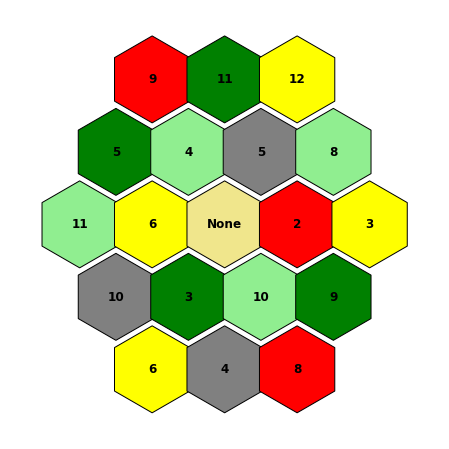

In [17]:
def refined_grid_search(num_iterations, num_ants, alpha, beta, evaporation_rate):
    best_score = float('inf')
    best_params = None
    best_solution = None
    best_balances = None

    for ni in [num_iterations - 200, num_iterations, num_iterations + 200]:
        for na in [num_ants - 2, num_ants, num_ants + 2]:
            for a in [alpha - 0.2, alpha, alpha + 0.2]:
                for b in [beta - 0.1, beta, beta + 0.2]:
                    for er in [evaporation_rate - 0.2, evaporation_rate, evaporation_rate + 0.2]:
                        solution, score, balances, times = ant_colony_optimization(num_iterations=num_iterations, num_ants=num_ants, alpha=alpha, beta=beta, evaporation_rate=evaporation_rate)
                        #print(f"Iterations: {ni}, Ants: {na}, Alpha: {a}, Beta: {b}, Evaporation Rate: {er}, Score: {score}")
                        if score < best_score:
                            best_score = score
                            best_params = (num_iterations, num_ants, alpha, beta, evaporation_rate)
                            best_solution = solution
                            best_balances = balances
                            best_time = times

    return best_params, best_score, best_solution, best_balances, best_time

# Perform the refined grid search with slight adjustments around the best found values
best_params, best_score, best_solution, best_balances, best_time = refined_grid_search(500, 10, 0.5, 0.5, 0.1) 

# Print the best parameters and score found
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Computation Time:", best_time)
plot_solution(best_solution)

## Genetic Algorithm

A **genetic algorithm** is a search heuristic inspired by the process of natural selection. It is used to generate high-quality solutions to optimization and search problems by relying on **bio-inspired operators** such as mutation, crossover, and selection.

In our Catan board optimization problem, each chromosome is a permutation of indices representing the placement of resource tiles on the Catan board. We use the same fitness function to evaluate each board configuration, similar to other algorithms, based on the non-adjacency of high-value numbers (6 and 8), non-adjacency of identical resources, and the balance of resource probabilities.


*Parameters:*
<ul>
<li>Population Size: number of individuals (solutions) in each generation</li>
<li>Number of Generations: how many iterations to run the algorithm</li>
<li>Mutation Rate: probability of mutation (in the position in the board configuration) for each individual</li>
<li>Crossover Rate: probability of crossover for each pair of parents</li>
</ul>

**Algorithm preparation:**

<ol>
<li>Population initialization: create set of random board configurations</li>
    
    - Input: population size, resource types counts and numerical token counts
    
    - Output: board configurations set and resource-token pairs
<li>Tournament selection: select parent configurations for crossover</li>
    
    - Input: board configurations set, resource-token pairs and number of parents to consider (k)

    - Output: two best board configurations based on evaluation function
<li>Crossover: generate new board configurations (offspring) by combining features from two parent boards</li>
    
    - Input: "parent" boards and crossover rate
    
    - Output: in case of crossover - "children" boards with the segments between the crossover points are
    copied from each parent to the corresponding child
<li>Mutation: random changes in aboard configuration</li>
    
    - Input: board and probability of mutation
    
    - Output: board with tiles swap
</ol>

**Genetic Algorithm:** iteratively evolving the population of board configurations to improve the board's fitness. 

Algorithm starts by generating an initial population of board configurations randomly, and iterates over num_generations:

<ul>
<li>Selects best performing parent boards </li>
<li>Creates new boards through crossover and mutation</li>
<li>Evaluates each board using defined evalution function to determine its fitness</li>
<li>Updates the population to retain the best board configurations: the best-performing board configurations are preserved for the next generation </li>
<li>Returns the best board configuration found after all generations</li>
</ul>

### Implementation

In [8]:
def genetic_algorithm(pop_size, num_generations, mutation_rate, crossover_rate, resource_counts, number_distribution):
    start_time = time.time()
    population, tuples = initialize_population(pop_size, resource_counts, number_distribution)
    
    for generation in range(num_generations): #for each generation
        new_population = []
        for _ in range(pop_size // 2): 
            #create a new population by selecting parents, performing crossover, and applying mutation
            parent1, parent2 = select_parents(population, tuples)
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        
        #select the best individuals to form the new population
        population = sorted(new_population, key=lambda ind: evaluate_solution_genetic(tuples, ind)[0])[:pop_size]  # keep the best solutions
        best_solution = population[0]
        best_score, _ = evaluate_solution_genetic(tuples, best_solution)
        #print(f'Generation {generation}: Best Score = {best_score}')

    best_solution = population[0]
    best_score, _ = evaluate_solution_genetic(tuples, best_solution)
    #print(f'Final Solution: Best Score = {best_score}')
    computation_time = time.time() - start_time
    return tuples, best_score, best_solution, computation_time

Best Solution: [12, 15, 9, 3, 7, 18, 13, 10, 17, 2, 5, 11, 1, 4, 14, 16, 0, 8, 6]
Best probability: {'brick': 0.2777777777777778, 'wood': 0.3055555555555555, 'sheep': 0.3888888888888889, 'wheat': 0.3055555555555556, 'stone': 0.3333333333333333}
Best Score: 3.766281194702798
Computation Time: 3.9218640327453613


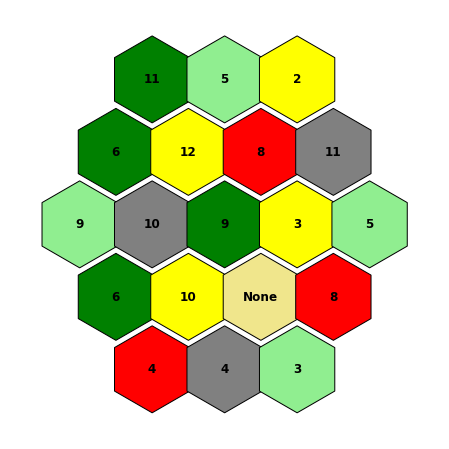

In [9]:
best_tuples, best_score, best_solution, computation_time = genetic_algorithm(POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE, CROSSOVER_RATE, resource_counts, number_distribution)
# print solution
print("Best Solution:", best_solution)
print("Best probability:", best_balances)
print("Best Score:", best_score)
print("Computation Time:", computation_time)
#plot the best solution found
plot_solution_genetic((best_tuples, best_solution))

### Hyperparameters tuning

In [10]:
results = []
def grid_search_genetic(param_combination):
    for params in param_combination:
        #print(f'Testing parameters: {params}')
        pop_size, num_generations, mutation_rate, crossover_rate = params

        best_tuples, best_score, best_solution, computation_time = genetic_algorithm(
            pop_size, num_generations, mutation_rate, crossover_rate, resource_counts, number_distribution
        )

        best_score, resource_probs = evaluate_solution_genetic(best_tuples, best_solution)
        results.append({
            'params': params,
            'best_score': best_score,
            'resource_probs': resource_probs
        })
    return results

results = grid_search_genetic(param_combinations_genetic)
#sort results by best score
results.sort(key=lambda x: x['best_score'])

#print the best results
best_params = results[0]['params']
best_score = results[0]['best_score']
best_resource_probs = results[0]['resource_probs']

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')
print(f'Best Resource Probabilities: {best_resource_probs}')

Best Score: 2.4721314364437768
Resource Probabilities: {'brick': 0.2777777777777778, 'wood': 0.3055555555555556, 'sheep': 0.4166666666666667, 'wheat': 0.33333333333333337, 'stone': 0.27777777777777773}


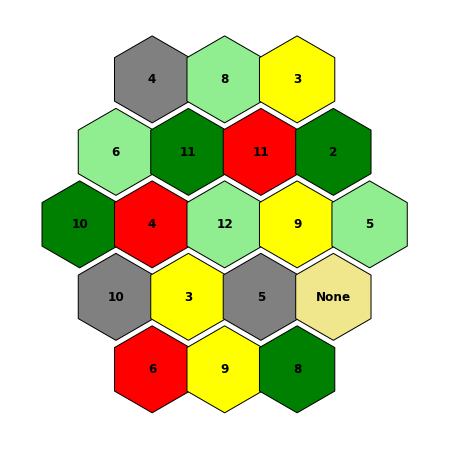

In [15]:
pop_size, num_generations, mutation_rate, crossover_rate = best_params

best_tuples, best_score, best_solution, computation_time = genetic_algorithm(
    pop_size, num_generations, mutation_rate, crossover_rate, resource_counts, number_distribution
)

best_score, resource_probs = evaluate_solution_genetic(best_tuples, best_solution)
print(f'Best Score: {best_score}')
print(f'Resource Probabilities: {resource_probs}')

plot_solution_genetic((best_tuples, best_solution))

## Simulated Annealing

Simulated Annealing (SA) is a probabilistic optimization algorithm inspired by the annealing process in metallurgy, where materials are heated and then slowly cooled to remove defects and optimize their structure. This algorithm is particularly useful for solving complex optimization problems where the search space is large and may contain many local optima. By mimicking the physical annealing process, SA aims to find a global optimum solution by allowing occasional uphill moves (worse solutions) to escape local optima, gradually reducing these moves as the algorithm progresses.

**Key concept**

- **Annealing Process**: The physical process of heating a material and then slowly cooling it to decrease its energy state and increase the size of its crystals.
- **Temperature**: A control parameter in SA that regulates the probability of accepting worse solutions. High temperature allows more exploration, while low temperature focuses on exploitation.
- **Cooling Schedule**: A strategy for decreasing the temperature over time. It can be linear, exponential, or logarithmic, affecting the convergence rate of the algorithm.
- **Probability of Acceptance**: The likelihood of accepting a worse solution, determined by the Metropolis criterion, which depends on the temperature and the change in the objective function value.
- **Neighbor point**: The definition of a neighbor in this context is similar to the process used in the Artificial Bee Colony algorithm. To generate a neighboring map, we randomly swap the positions of two resource tiles or two number tokens on the map. This approach maintains the integrity of the map while providing a variation that can be evaluated for better balance.


**Algorithm**

The pseudocode for simulated annealing:

> Initialize the initial solution S0
> Set initial temperature T

> **Repeat** until stopping criteria is met
>>    Generate a new solution S' from the neighborhood of S0

>>    Evaluate the objective function values f(S0) and f(S')

>>    If f(S') < f(S0) then
>>>        S0 = S'
>>    Else
>>>        Accept S' with probability P = exp(-ΔE / T)

>>    Update the temperature T according to the cooling schedule

> **Return** the best solution found

Best Solution: [('brick', 3), ('sheep', 6), ('brick', 5), ('desert', None), ('stone', 3), ('wood', 4), ('wheat', 8), ('wood', 6), ('wheat', 4), ('brick', 12), ('sheep', 11), ('stone', 10), ('sheep', 5), ('stone', 11), ('wheat', 9), ('wood', 8), ('wheat', 10), ('wood', 2), ('sheep', 9)]
Best Score: 0.13094570021973115
Best Resource Probabilities: {'brick': 0.19444444444444442, 'wood': 0.3888888888888889, 'sheep': 0.4166666666666667, 'wheat': 0.41666666666666663, 'stone': 0.19444444444444445}
Best Computation Time: 0.525183916091919


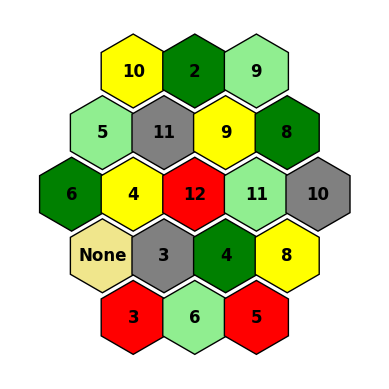

In [10]:
def simulated_annealing(Tmax, Tmin, r, NT):
    # get hyperparameters
    start_time = time.time()

    # init outputs
    temp = Tmax
    solution_min = create_initial_solution()
    score_min, _ = evaluate_solution(solution_min)

    while temp > Tmin:              
        for _ in range(NT):         
            solution_new =  get_neighbor(solution_min)    # picking a neighbor
            score_new, resource_probs_new  = evaluate_solution(solution_new)       
            if  np.exp((score_min-score_new)/temp) > np.random.rand():            
                solution_min= solution_new                                               
                score_min = score_new   
                best_resource_probs = resource_probs_new                                                         
        temp *= r
    computation_time = time.time() - start_time
    return solution_min, score_min, best_resource_probs, computation_time

# Test the SA implementation
best_solution, best_score, best_resource_probs,best_time = simulated_annealing(500, 0.1, 0.85, 500)
print("Best Solution:", best_solution)
print("Best Score:", best_score)
print("Best Resource Probabilities:", best_resource_probs)
print("Best Computation Time:", best_time)

plot_solution(best_solution)

**Hyperparameter tuning**

Simulated Annealing (SA) has several key parameters that can be tuned to influence the algorithm's performance and efficiency. These parameters determine how simulated annealing balances exploration (searching broadly for solutions) and exploitation (refining promising solutions) throughout its iterative process:  

1. **kT** (repetitions per temperature): Represents the number of iterations at each temperature during simulated annealing. Higher values allow more exploration of the solution space at each temperature level. Lower values prioritize exploitation of the current solution.

2. **r** (cooling rate): Determines how quickly the temperature decreases during the annealing process. A higher cooling rate means the temperature decreases faster.Lower rates allow for more exploration (slower cooling), while higher rates focus on exploitation (faster cooling). 

3. **Tmax** (maximal temperature to start): Initial temperature from which the annealing process begins. Higher Tmax values encourage exploration by accepting more suboptimal solutions early in the process. 

4. **Tmin** (minimal temperature to end): The temperature at which the annealing process stops. Lower Tmin values terminate the annealing sooner, possibly preventing further exploration but ensuring more exploitation.

In [24]:
def grid_search(Tmax, Tmin, r, NT):
    best_score = float('inf')
    best_params = None
    best_solution = None
    best_balances = None

    for NT_ in list(range(NT-200, NT+200, 50)):
        for r_ in [0.05, 0.1, 0.2, 0.3]:
            for Tmin_ in [0.05, 0.1, 0.15, 0.2]:
                for Tmax_ in list(range(Tmax - 100, Tmax+100, 50)):
                    solution, score, balances, times = simulated_annealing(Tmax_, Tmin_, r_, NT_)
                    if score < best_score:
                        best_score = score
                        best_params = (Tmax_, Tmin_, r_, NT_)
                        best_solution = solution
                        best_balances = balances
                        best_time = times

    return best_params, best_score, best_solution, best_balances, best_time

# Perform the refined grid search with slight adjustments around the best found values
best_params, best_score, best_solution, best_balances, best_time = grid_search(500, 0.05, 0.3, 1000) 

# Print the best parameters and score found
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Computation Time:", best_time)
plot_solution(best_solution)


## Artifical Bee Colony

The **Artificial Bee Colony (ABC) algorithm,** introduced by Derviş Karaboğa in 2005, is a nature-inspired optimization technique based on the **foraging behavior of honey bees**. This algorithm is used to tackle both numerical and combinatorial optimization problems by simulating the intelligent foraging strategies of honey bee swarms. In the ABC algorithm, food sources represent potential solutions, **employed bees** are associated with specific food sources to gather information about their quality, **onlooker bees** choose food sources based on quality information shared by employed bees, and **scout bees** search for new food sources when current ones are abandoned due to suboptimality. The algorithm begins with the initialization of a random population of food sources, followed by an employed bee phase where each employed bee modifies its associated food source to find a new candidate solution, applying a greedy selection process to keep the better solution. In the onlooker bee phase, onlookers probabilistically select food sources based on their fitness, generate new solutions, and again apply greedy selection. If a food source is abandoned, scout bees introduce new random solutions. This process iterates until a termination criterion, such as a maximum number of cycles or a satisfactory fitness level, is met. The ABC algorithm effectively balances exploration and exploitation to find optimal solutions, making it a versatile tool for various optimization challenges.

**Key concept**

- Food Sources: In the context of optimization, food sources represent potential solutions to the problem.
- Employed Bees: These bees are associated with specific food sources and exploit them to gather information about their quality (fitness value).
- Onlooker Bees: These bees wait in the hive and choose food sources based on the quality information shared by employed bees, utilizing a probability-based selection process.
- Scout Bees: When a food source is abandoned (due to being suboptimal for a certain number of cycles), scout bees search for new food sources randomly to explore the search space.
- Colony Structure: The bee colony consists of three groups: employed bees, onlooker bees, and scout bees, working collaboratively to explore and exploit the search space.

**Neighbor point definition**

In the context of the Catan problem, each point represents a specific map configuration. To generate a neighboring point (or map) in the Artificial Bee Colony algorithm for balancing the Catan map, I randomly perform one of the following operations:
- Swap two resource positions: Randomly select two resource tiles on the map and switch their positions. This changes the distribution of resources on the map while maintaining the same types of resources.
- Swap two number positions: Randomly select two number tokens on the map and switch their positions. This alters the distribution of number tokens, potentially affecting the resource yield probabilities while keeping the same numbers in play.

These operations ensure that the new neighboring map maintains a valid Catan configuration while providing a variation that can be evaluated for improved balance.


**Algorithm**

Pseudocode of bee artificial colony algorithm

> **Initialize** the population of food sources (solutions) randomly
> **Evaluate** the fitness of each food source

> **Repeat** until termination criteria are met
>> For each employed bee
>>>        Generate a new solution by modifying the current solution
>>>        Evaluate the new solution
>>>        Apply greedy selection (if current solution have the minimal score, then replace solution)

>>    Calculate the probability of each solution being selected by onlookers

>>  For each onlooker bee
>>>        Select a food source based on probability
>>>        Generate a new solution by modifying the selected solution
>>>        Evaluate the new solution
>>>        Apply greedy selection (if current solution have the minimal score, then replace solution)

>>    If a food source is abandoned, replace with a new random solution

> **Return** the best solution



Best Solution: [('brick', 6), ('wheat', 3), ('stone', 9), ('stone', 10), ('stone', 11), ('wood', 12), ('sheep', 5), ('sheep', 8), ('brick', 3), ('wheat', 8), ('desert', None), ('wheat', 4), ('wood', 11), ('sheep', 2), ('brick', 9), ('wood', 10), ('wheat', 4), ('wood', 5), ('sheep', 6)]
Best Score: 2.8485568521267575
Best Resource Probabilities: {'brick': 0.3055555555555556, 'wood': 0.2777777777777778, 'sheep': 0.4166666666666667, 'wheat': 0.3611111111111111, 'stone': 0.24999999999999997}
Computation Time: 1.8813202381134033


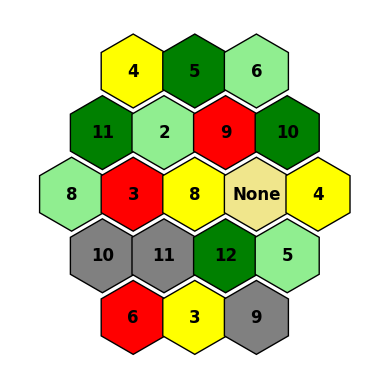

In [7]:
# Function to perform Artificial Bee Colony (ABC) optimization
def artificial_bee_colony_optimization(num_iterations=NUM_INTERATIONS, 
                                       num_employed_bees=NUM_EMPLOYEE_BEES, 
                                       num_onlooker_bees=NUM_ONLOOKER_BEES, max_trials=TRIAL_LIMIT):    
    start_time = time.time()
    # Main ABC loop
    for iteration in range(num_iterations):
        
        #set up
        employed_population = initialize_population_abc(num_employed_bees)
        # Track the best solution found
        best_bee = min(employed_population, key=lambda x: x['fitness'])
        best_solution = best_bee['position']
        best_score = best_bee['fitness']
    
        # Employed bee phase
        for bee in employed_population:
            neighbor_position = get_neighbor(bee['position'])
            neighbor_score, _ = evaluate_solution(neighbor_position)
            # Greedy selection
            if neighbor_score < bee['fitness']:
                bee['position'] = neighbor_position
                bee['fitness'] = neighbor_score
                bee['trial'] = 0
            else:
                bee['trial'] += 1

        # Onlooker bee phase
        total_fitness = sum([1.0 / bee['fitness'] for bee in employed_population])
        probabilities = [1.0 / (bee['fitness'] * total_fitness) for bee in employed_population]
        for i in range(num_onlooker_bees):
            select_bee_ind = random.choices(range(len(employed_population)), weights=probabilities)[0]
            select_bee = employed_population[select_bee_ind]
            neighbor_position = get_neighbor(select_bee['position'])
            neighbor_score, _ = evaluate_solution(neighbor_position)
            # Determine if the new solution is better
            if neighbor_score < select_bee['fitness']:
                select_bee['position'] = neighbor_position
                select_bee['fitness'] = neighbor_score
                select_bee['trial'] = 0
            else:
                select_bee['trial'] += 1

        # Scout bee phase (abandon solution if no improvement)
        for bee in employed_population:
            if bee['trial'] >= TRIAL_LIMIT:
                bee['position'] = create_initial_solution()
                bee['fitness'] = evaluate_solution(bee['position'])[0]
                bee['trial'] = 0

        # Update best solution found so far
        current_bee = min(employed_population, key=lambda x: x['fitness'])
        current_solution = current_bee['position']
        current_score = current_bee['fitness']
        if current_score < best_score:
            best_solution = current_solution
            best_score = current_score
            _, best_resource_probs = evaluate_solution(best_solution)
    computation_time = time.time() - start_time
    return best_solution, best_score, best_resource_probs, computation_time

# Test the ABC implementation
best_solution, best_score, best_resource_probs, computation_time = artificial_bee_colony_optimization()
print("Best Solution:", best_solution)
print("Best Score:", best_score)
print("Best Resource Probabilities:", best_resource_probs)
print("Computation Time:", computation_time)
plot_solution(best_solution)

**Hyperparameter tuning**

To achieve improved results, hyperparameter tuning is essential. We employed grid search to identify the optimal parameters for the problem: 
1. **Number of Employed Bees** :Controls the number of solutions (employed bees) that search for new solutions in each iteration.Increasing SN can enhance exploration ability but may also increase computational cost.
2. **Number of Onlooker Bees** : Determines how many employed bees' solutions are considered by onlooker bees for further exploration. Adjusting SN can balance exploitation and exploration; a higher SN increases exploration but may reduce exploitation.
3. **Maximum trials** :Controls the number of solutions discarded (abandoned solutions) by scout bees after a certain number of iterations without improvement. Setting a higher Limit allows more exploration by discarding poor solutions, but too high a Limit may reduce the diversity of solutions.


In [17]:
def grid_search(num_iterations, num_employed_bees, num_onlooker_bees, max_trials):
    best_score = float('inf')
    best_params = None
    best_solution = None
    best_balances = None

    for ni in list(range(num_iterations-200, num_iterations+200, 50)):
        for neb in list(range(num_employed_bees - 10, num_employed_bees+20, 5)):
            for neo in list(range(num_onlooker_bees - 10, num_onlooker_bees+10, 5)):
                for trial in list(range(max_trials - 5, max_trials+5, 2)):
                    solution, score, balances, times = artificial_bee_colony_optimization(ni, neb, neo, trial)
                    if score < best_score:
                        best_score = score
                        best_params = (ni, neb, neo, trial)
                        best_solution = solution
                        best_balances = balances
                        best_time = times

    return best_params, best_score, best_solution, best_balances, best_time

# Perform the refined grid search with slight adjustments around the best found values
best_params, best_score, best_solution, best_balances, best_time = grid_search(1000, 20, 20, 10) 

# Print the best parameters and score found
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Computation Time:", best_time)
plot_solution(best_solution)


# COMPARISON

In evaluating heuristic algorithms, optimizing hyperparameters is crucial to achieve the best possible solution quality. The primary metric for assessing these algorithms is typically the quality of the solutions they produce, measured by a score that aims to be as low as possible. This reflects how effectively the algorithm can find optimal or near-optimal solutions to a given problem.

However, solution quality is not the sole criterion. 
- **Computational time**, which measures how long an algorithm takes to execute, is equally important. Faster algorithms are generally more desirable, particularly for large-scale or time-sensitive applications.
- Evaluating the **robustness** of algorithms is equally important. Robustness refers to their consistency and performance across problem instances or under varying conditions.

Running each algorithm multiple times with the optimized hyperparameters, as done in this comparison (100 runs per algorithm), helps assess both computational efficiency and robustness, alongside solution quality. This final part of the notebook ensures a balanced assessment of all heuristic algorithms, considering their performance across solution quality, computational time, and robustness. It aids in selecting algorithms that not only produce high-quality solutions but also operate efficiently and reliably in practical scenarios.

In [15]:
num_runs = 100
results = {
    'Algorithm': [],
    'Run': [],
    'Best Score': [],
    'Computation Time': []
}

algorithms = {
    'Ant Colony': lambda : ant_colony_optimization(500, 10, 0.5, 0.5, 0.1),
    'Genetic Algorithm' : lambda : genetic_algorithm(100, 700, 0.1, 0.7, resource_counts, number_distribution),
    'Simulated Annealing': lambda : simulated_annealing(500, 0.1, 0.85, 500),
    'Artificial Bee Colony': lambda : artificial_bee_colony_optimization(500, 50, 50, 10)
}

# Run each algorithm 100 times and record the results
for alg_name, alg_func in algorithms.items():
    print(f'Starting 100 runs for {alg_name}!')
    for run in range(num_runs):
        _, best_score, _, computation_time = alg_func()
        results['Algorithm'].append(alg_name)
        results['Run'].append(run + 1)
        results['Best Score'].append(best_score)
        results['Computation Time'].append(computation_time)
        if (run + 1) % 25 == 0:
            print(f'Currently at run {run + 1} for {alg_name}...')
    print(f'Finished 100 runs for {alg_name}!')
print('All runs completed.')


df_results = pd.DataFrame(results)
df_results.to_csv('heuristics_comparison_results.csv', index=False)

Starting 100 runs for Ant Colony!
Currently at run 25 for Ant Colony...
Currently at run 50 for Ant Colony...
Currently at run 75 for Ant Colony...
Currently at run 100 for Ant Colony...
Finished 100 runs for Ant Colony!
Starting 100 runs for Genetic Algorithm!
Currently at run 25 for Genetic Algorithm...
Currently at run 50 for Genetic Algorithm...
Currently at run 75 for Genetic Algorithm...
Currently at run 100 for Genetic Algorithm...
Finished 100 runs for Genetic Algorithm!
Starting 100 runs for Simulated Annealing!
Currently at run 25 for Simulated Annealing...
Currently at run 50 for Simulated Annealing...
Currently at run 75 for Simulated Annealing...
Currently at run 100 for Simulated Annealing...
Finished 100 runs for Simulated Annealing!
Starting 100 runs for Artificial Bee Colony!
Currently at run 25 for Artificial Bee Colony...
Currently at run 50 for Artificial Bee Colony...
Currently at run 75 for Artificial Bee Colony...
Currently at run 100 for Artificial Bee Colony...

In [19]:
print(df_results.head())

    Algorithm  Run  Best Score  Computation Time
0  Ant Colony    1    2.346450          2.738941
1  Ant Colony    2    0.686501          2.595686
2  Ant Colony    3    1.210726          2.607086
3  Ant Colony    4    0.809504          2.539642
4  Ant Colony    5    2.346450          2.842268


**Robustness Comparison**

The boxplot below compares the robustness of different heuristic algorithms across multiple runs. Robustness here is measured by the consistency in achieving good solutions, reflected in the best scores obtained. Each box represents the distribution of best scores from 100 runs of each algorithm with optimized hyperparameters.

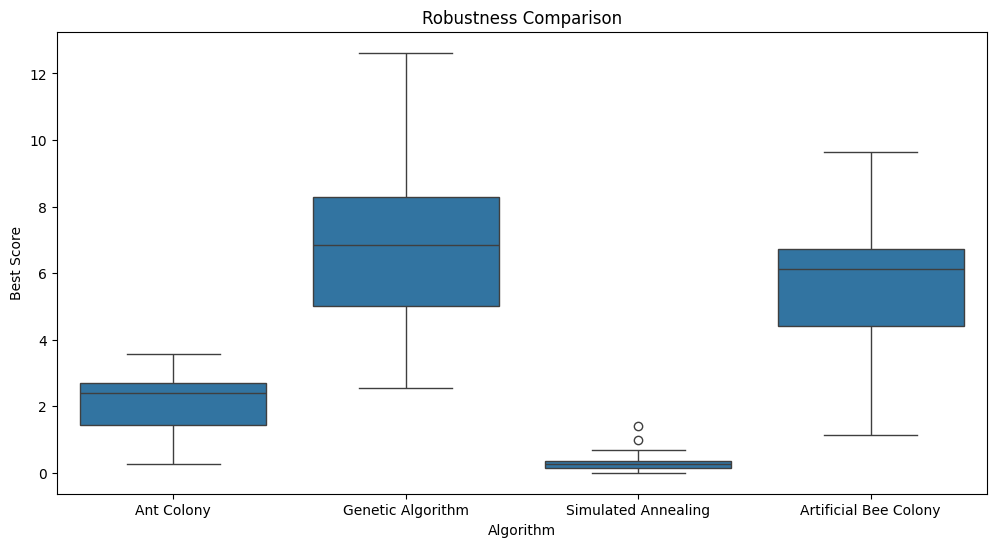

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Algorithm', y='Best Score', data=df_results)
plt.title('Robustness Comparison')
plt.ylabel('Best Score')
plt.xlabel('Algorithm')
plt.show()

1. **Performance Distribution**:
   - Ant Colony Optimization (ACO) has the second lowest median score among the algorithms, indicating it generally performs well. The range between the first quartile and the third quartile is narrow, suggesting consistent performance. The whiskers and minimum value indicate that ACO occasionally finds very low scores.
   - Genetic Algorithm (GA) has a higher median score compared to ACO, and the interquartile range (IQR) is wider. This indicates more variability in performance. The whiskers and higher maximum value suggest that GA's performance can be more unpredictable.
   - Simulated Annealing (SA) shows the lowest overall scores and the tightest IQR, indicating very consistent and robust performance. The median is very low, and the scores are tightly clustered, which is promising for reliability.
   - Artificial Bee Colony (ABC) has a higher median score than ACO and SA but similar to GA. The IQR is moderate, showing some variability in performance. The whiskers indicate that while ABC can achieve low scores, it can also have higher scores.

2. **Median Performance**:
   - SA has the lowest median, followed by ACO, indicating that these two algorithms tend to perform best on average.
   - GA and ABC have higher medians, suggesting they may not be as effective on average compared to ACO and SA.

3. **Variability**:
   - SA has the least variability (smallest IQR), indicating it is the most consistent algorithm.
   - ACO also shows relatively low variability.
   - GA has the highest variability, indicating that its performance can be quite inconsistent.
   - ABC shows moderate variability.

4. **Outliers**:
   - SA has a few outliers, indicating occasional runs where the performance was significantly different (either better or worse) from the majority of runs.
   - The other algorithms do not show significant outliers, suggesting their performance is more predictable within their respective ranges.

5. **Conclusion**:

- Simulated Annealing is the most robust algorithm, given its low median score, tight IQR, and overall consistency.
- Ant Colony Optimization also performs well, with a low median score and relatively low variability, making it a reliable choice.
- Genetic Algorithm** and Artificial Bee Colony show more variability and higher median scores, indicating they may not be as reliable as SA or ACO for this particular problem.

**Computational Time Comparison**

The boxplot below compares the computational time required by each heuristic algorithm to find optimal solutions. Computational time is measured in seconds and reflects how efficient each algorithm is in executing its search process. Each box represents the distribution of computational times across 100 runs for each algorithm.

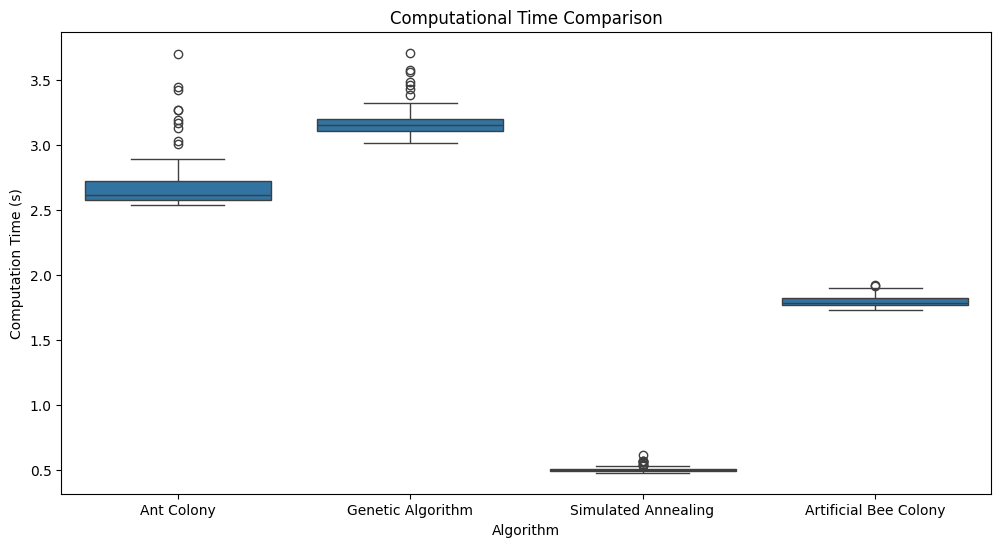

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Algorithm', y='Computation Time', data=df_results)
plt.title('Computational Time Comparison')
plt.ylabel('Computation Time (s)')
plt.xlabel('Algorithm')
plt.show()

1. **Median Computational Time**:
   - Simulated Annealing (SA) has the lowest median computational time, indicating it is the fastest algorithm among the four.
   - Artificial Bee Colony (ABC) has a median computational time higher than SA but lower than ACO and GA, suggesting it is relatively fast but not the fastest.
   - Ant Colony Optimization (ACO) shows a moderate median computational time, higher than SA and ABC.
   - Genetic Algorithm (GA) has the highest median computational time, indicating it is the slowest among the four algorithms.

2. **Variability**:
   - SA has a very tight interquartile range (IQR), indicating very consistent computational times with minimal variability.
   - ABC also shows low variability in computational time, though slightly more than SA.
   - GA shows moderate variability, with a slightly wider IQR compared to SA and ABC.
   - ACO shows the most variability in computational time, with a wider IQR and many outliers, indicating inconsistent performance in terms of time.

3. **Outliers**:
   - ACO as numerous outliers, indicating that some runs took significantly longer than others.
   - GA also has a few outliers, but not as many as ACO.
   - SA and ABC show very few or no outliers, suggesting consistent computational times across different runs.

4. **Conclusion**

    - Simulated Annealing is the fastest algorithm, with the lowest median computational time and minimal variability, making it highly efficient.
    - Artificial Bee Colony is also relatively fast with low variability, making it a good choice when both speed and consistency are important.
    - Ant Colony Optimization has a moderate computational time but is the most variable in terms of computational time, making it less efficient than SA and ABC but still reasonably consistent.
    - Genetic Algorithm is the slowest and and has moderate variability, indicating it may not be the best choice if time efficiency is a critical factor.

# CONCLUSION

**Ant Colony Optimization (ACO)** is a metaheuristic inspired by the foraging behavior of ants, designed to solve combinatorial optimization problems. ACO excels in scenarios like the Catan board configuration by leveraging the collective behavior of ants to find high-quality solutions. It maintains a good balance of exploration and exploitation, effectively navigating the search space to avoid local optima. Additionally, ACO can generate parallel solutions, enhancing the efficiency and robustness of the algorithm. However, ACO can be slower compared to other algorithms due to its iterative process and the large number of ants or iterations required for effective exploration. It also involves complex hyperparameter tuning, with parameters such as the pheromone influence, heuristic influence, and evaporation rate needing careful adjustment to achieve optimal performance. The effectiveness of ACO is dependent on the quality of heuristics, with poor heuristics potentially leading to suboptimal solutions.

**The Genetic Algorithm** provides an effective approach to optimizing the placement of resource tiles and number tokens on the Catan board. It explores a large solution space of potential Catan board configurations by maintaining a diverse population and applying selection, crossover, and mutation operators. Survival mechanism of genetic algorithm helps to keep good solutions ensuring that the best-performing solutions from one generation are preserved and carried over to the next generation.However, genetic algorithms can get stuck in local optima, particularly if the population diversity decreases too quickly. Similar to other metaheuristics, they are sensitive to parameter settings such as population size, mutation rate, and crossover rate.

**Simulated Annealing (SA)**, among the four algorithms, performs the best and doesn't take too much time. It's easy to use and understand, making it suitable for different types of optimization problems, including discrete optimization problem like balancing a Catan map. SA is good at avoiding getting stuck in local optima by sometimes accepting worse solutions, which helps find a more balanced map. The cooling schedule helps SA gradually focus on improving solutions, leading to more thorough searches and better-balanced maps. However, like other heuristic algorithms, SA doesn't always find the perfect solution. This means it might not always give you a perfectly balanced Catan map, and the results can vary each time you run it.

**The Artificial Bee Colony algorithm** is easy to understand and use. It works well for large and complex problems, like balancing a Catan map. Because it mimics how bee colonies work, it does a good job of exploring new areas and improving good solutions. However, it can take a lot of time to run for large problems because it needs to create and check many solutions. Its performance depends a lot on the right settings, so you need to spend time finding the best parameters. Additionally, the results can vary each time you run it due to its random nature, often requiring multiple runs to get a good solution, which takes even more time.

**Simulated Annealing is the most robust algorithm**, consistently achieving the best scores with minimal variability. Ant Colony Optimization also shows strong performance with low variability. The Genetic Algorithm and Artificial Bee Colony show more variability and less consistent performance.

**Simulated Annealing is the fastest algorithm**, with the lowest and most consistent computational times. Artificial Bee Colony is also relatively fast and consistent. Ant Colony Optimization has moderate computational times with the most variability, while Genetic Algorithm is the slowest with moderate variability, making it less suitable for time-sensitive applications.

### Reference

Saraiva, Rommel et.al. 2020 [Using Ant Colony Optimisation for map generation and improving game balance in the Terra Mystica and Settlers of Catan board games](https://www.researchgate.net/publication/344758433_Using_Ant_Colony_Optimisation_for_map_generation_and_improving_game_balance_in_the_Terra_Mystica_and_Settlers_of_Catan_board_games)

Marco Dorigo, Thomas Stützle. 2018 [Ant Colony Optimization: Overview and Recent Advances](https://doi.org/10.1007/978-3-319-91086-4_10)

Sourabh Katoch, Sumit Singh Chauhan, Vijay Kumar. 2020 [A review on genetic algorithm: past, present, and future](https://doi.org/10.1007/s11042-020-10139-6)

Henderson et.al 2006 [The Theory and Practice of Simulated Annealing](https://www.researchgate.net/publication/225260290_The_Theory_and_Practice_of_Simulated_Annealing)

Karaboga et.al 2005[An Idea Based on Honey Bee Swarm for Numerical Optimization](https://www.researchgate.net/publication/255638348_An_Idea_Based_on_Honey_Bee_Swarm_for_Numerical_Optimization_Technical_Report_-_TR06)

Karaboga et.al 2007[Artificial Bee Colony (ABC) Optimization Algorithm for Solving Constrained Optimization Problems](https://www.researchgate.net/publication/221498082_Artificial_Bee_Colony_ABC_Optimization_Algorithm_for_Solving_Constrained_Optimization_Problems)